# Load Required Packages

In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
import shap
import lime
import sklearn 
import warnings
import xgboost
import itertools
import gc

import multiprocessing as mp
import time
import pickle 
import interpret
import collections
import math
import random
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  RandomForestRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn import preprocessing
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.preprocessing import LabelEncoder
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostRegressor
%matplotlib inline
import os, sys
#import statsmodels.api as sm
sys.path.append(os.path.abspath("../../../"))

pd.set_option('display.max_columns', None)
import eli5
from eli5.sklearn import PermutationImportance

import sys
print(sys.path)
sys.path.append("/anaconda3/lib/python3.6/site-packages")


['/Users/brianliu/Desktop/Interpretable Clusters', '/opt/anaconda3/lib/python37.zip', '/opt/anaconda3/lib/python3.7', '/opt/anaconda3/lib/python3.7/lib-dynload', '', '/opt/anaconda3/lib/python3.7/site-packages', '/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/Users/brianliu/.ipython', '/Users', '/anaconda3/lib/python3.6/site-packages', '/Users']


# Load Test Data

In [238]:
titanic = pd.read_csv('titanic_data.csv')
#titanic
full_data = titanic
full_data = full_data.drop(['PassengerId'], axis=1)

import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
full_data['Cabin'] = full_data['Cabin'].fillna("U0")
full_data['Deck'] = full_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
full_data['Deck'] = full_data['Deck'].map(deck)
full_data['Deck'] = full_data['Deck'].fillna(0)
full_data['Deck'] = full_data['Deck'].astype(int)

full_data = full_data.drop('Cabin', axis = 1)

mean = full_data["Age"].mean()
std = full_data["Age"].std()
is_null = full_data["Age"].isnull().sum()
# compute random numbers between the mean, std and is_null
rand_age = np.random.randint(mean - std, mean + std, size = is_null)
# fill NaN values in Age column with random values generated
age_slice = full_data["Age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
full_data["Age"] = age_slice
full_data["Age"] = full_data["Age"].astype(int)
full_data["Age"].isnull().sum()
full_data['Embarked'] = full_data['Embarked'].fillna('S')


full_data['Fare'] = full_data['Fare'].fillna(0)
full_data['Fare'] = full_data['Fare'].astype(int)
full_data = full_data.drop(['Name'], axis=1)
full_data = full_data.drop(['Ticket'], axis=1)
full_data['Sex'] = full_data['Sex'].map({"male": 0, "female": 1})


full_data_train,full_data_test = train_test_split(full_data,test_size = 0.3,random_state = 10)

full_data = pd.get_dummies(full_data,columns = ['Pclass','Embarked','Deck'])
full_data = full_data.dropna().reset_index().drop('index',axis = 1)
X = full_data.drop('Survived',axis = 1)
cols = X.columns
y = full_data['Survived']
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X =pd.DataFrame(X, columns = cols)
xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size = 0.3,random_state = 10)


https://scikit-learn.org/dev/auto_examples/tree/plot_unveil_tree_structure.html

# Random Forest With Tree Distances

In [240]:
def get_node_depths(tree1):
    def get_node_depths_(current_node, current_depth, l, r, depths):
        depths += [current_depth]
        if l[current_node] != -1 and r[current_node] != -1:
            get_node_depths_(l[current_node], current_depth + 1, l, r, depths)
            get_node_depths_(r[current_node], current_depth + 1, l, r, depths)
    depths = []
    get_node_depths_(0, 0, tree1.tree_.children_left, tree1.tree_.children_right, depths) 
    return np.array(depths)

def get_shared_nodes(i1,i2,node_indicator,n_nodes):
    sample_ids = [i1, i2]
    common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                    len(sample_ids))
    
    common_node_id = np.arange(n_nodes)[common_nodes]
    
    return common_node_id

# Tree distance between nodes n1, n2 = depth(n1) + depth(n2) - 2 depth(LCA)
def distance_between_samples(indexes,depths,leaves,node_indicator,n_nodes):
    i1 = indexes[0]
    i2 = indexes[1]
    leaf_node1 = leaves[i1]
    leaf_node2 = leaves[i2]
    depth_node1 = depths[leaf_node1]
    depth_node2 = depths[leaf_node2]
    ancestors = get_shared_nodes(i1,i2,node_indicator,n_nodes)
    depth_LCA = max(depths[ancestors])
    
    dist = depth_node1 + depth_node2 - 2*depth_LCA
    
    return dist

In [241]:
# bootstraps data and builds a tree, then calculates pairwise distances on the data instances relative to the tree
# Tree distance is calculated via lowest common ancestor
def build_tree(xTrain,yTrain,xTest,X):
    train = xTrain.copy()
    train['y'] = yTrain
    train1 = train.sample(n = len(train), replace = True) 
    yTrain1 = train1['y']
    xTrain1 = train1.drop('y',axis = 1)
    gc.collect()
    estimator = DecisionTreeClassifier().fit(xTrain1,yTrain1)
    n_nodes = estimator.tree_.node_count
    depths = get_node_depths(estimator)
    leaves_train = estimator.apply(xTrain)
    leaves_test = estimator.apply(xTest)
    node_indicator_test = estimator.decision_path(xTest)
    node_indicator_train = estimator.decision_path(xTrain)
    train_comb = list(itertools.combinations(range(0,len(xTrain)), 2))
    test_comb = list(itertools.combinations(range(0,len(xTest)), 2))

    ### Train Distances
    train_distances = []
    for indexes in train_comb:
        dist = distance_between_samples(indexes,depths,leaves_train,node_indicator_train,n_nodes)
        train_distances.append([indexes[0],indexes[1],dist])

    ### Test Distances
    test_distances = []
    for indexes in test_comb:
        dist = distance_between_samples(indexes,depths,leaves_test,node_indicator_test,n_nodes)
        test_distances.append([indexes[0],indexes[1],dist])

    train_dist_df = pd.DataFrame(train_distances, columns = ['i1','i2','tree_dist'])
    test_dist_df = pd.DataFrame(test_distances, columns = ['i1','i2','tree_dist'])
    
    leaves_all = estimator.apply(X)
    node_indicator_all = estimator.decision_path(X)
    dist_args = [depths,leaves_all,node_indicator_all,n_nodes]
    
    return([estimator,train_dist_df,test_dist_df,dist_args])

In [242]:
def fit_random_forest(xTrain,yTrain,num_trees,xTest,X):
    i = 0
    mods = []
    dist_args = []
    train_dists = pd.DataFrame()
    test_dists = pd.DataFrame()
    while i <= num_trees:
        tree = build_tree(xTrain,yTrain,xTest,X)
        mods.append(tree[0])
        train_dists = train_dists.append(tree[1])
        test_dists = test_dists.append(tree[2])
        dist_args.append(tree[3])
        i = i+1
    train_final_dist = train_dists.groupby(['i1','i2']).mean().reset_index()
    test_final_dist = test_dists.groupby(['i1','i2']).mean().reset_index()
    return(mods,train_final_dist,test_final_dist,dist_args)

def rf_predict(xTest,mods):
    pred = []
    for clf in mods:
        pred.append(clf.predict(xTest))
    pred = np.mean(pred,axis = 0)
    pred = [int(x) for x in pred>=0.5]
    return pred

In [243]:
# Build Trees and Calculate Distances

mods,train_final_dist,test_final_dist,dist_args = fit_random_forest(xTrain,yTrain,10,xTest,X)
train_final_dist = train_final_dist.groupby(['i1','i2']).mean().reset_index()
test_final_dist = test_final_dist.groupby(['i1','i2']).mean().reset_index()

test_final_dist1 = test_final_dist.copy()
test_final_dist1['i1'] = test_final_dist['i2']
test_final_dist1['i2'] = test_final_dist['i1']
test_final_dist = test_final_dist.append(test_final_dist1)
dist = np.zeros(shape = (max(test_final_dist['i1'])+1,max(test_final_dist['i1'])+1))
for i in range(0,len(test_final_dist)):
    temp = test_final_dist.iloc[i]
    i1 = int(temp['i1'])
    i2 = int(temp['i2'])
    tree_dist = temp['tree_dist']
    dist[i1][i2] = tree_dist

train_final_dist1 = train_final_dist.copy()
train_final_dist1['i1'] = train_final_dist['i2']
train_final_dist1['i2'] = train_final_dist['i1']
train_final_dist = train_final_dist.append(train_final_dist1)
dist_train = np.zeros(shape = (max(train_final_dist['i1'])+1,max(train_final_dist['i1'])+1))
for i in range(0,len(train_final_dist)):
    temp = train_final_dist.iloc[i]
    i1 = int(temp['i1'])
    i2 = int(temp['i2'])
    tree_dist = temp['tree_dist']
    dist_train[i1][i2] = tree_dist


# Agglomerative Clustering

In [244]:
### Test quality of cluster agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters = 3).fit(dist_train)
clusters = pd.DataFrame(np.column_stack((yTrain,clustering.labels_)),columns = ['y','clust'])
acc_clust = clusters.groupby('clust').mean()['y']
cont_clust =clusters.groupby('clust').count()['y']
print(acc_clust)
print(cont_clust)


clust
0    0.743363
1    0.109312
2    0.353333
Name: y, dtype: float64
clust
0    226
1    247
2    150
Name: y, dtype: int64


scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


# Partitioning About Mediods
https://en.wikipedia.org/wiki/K-medoids#Demonstration_of_PAM

In [245]:
### PAM test
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import read_sample

cluster_list = np.zeros(len(dist_train))
initial_medoids = []
nclusters = 3
for i in range(nclusters):
    initial_medoids.append(random.randint(0,len(dist_train)-1))


kmedoids_instance = kmedoids(dist_train, initial_medoids, data_type='distance_matrix')
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

cluster_list
for i in range(len(clusters)):
    cluster_list[clusters[i]] = i

clusters = pd.DataFrame(np.column_stack((yTrain,cluster_list)),columns = ['y','clust'])
acc_clust = clusters.groupby('clust').mean()['y']
cont_clust =clusters.groupby('clust').count()['y']
print('     ')
print('train')
print(acc_clust)
print(cont_clust)

centers = np.array(xTrain.iloc[medoids])
test_clust = []
for i in range(len(xTest)):
    temp = np.array(xTest.iloc[i])
    dist_list = []
    for i in range(len(centers)):
        dist_list.append(np.mean((temp - centers[i])**2))
    test_clust.append(dist_list.index(min(dist_list)))
test_clust

print('   ')
print('test')
clusters = pd.DataFrame(np.column_stack((yTest,test_clust)),columns = ['y','clust'])
acc_clust = clusters.groupby('clust').mean()['y']
cont_clust =clusters.groupby('clust').count()['y']
print(acc_clust)
print(cont_clust)

     
train
clust
0.0    0.114815
1.0    0.743363
2.0    0.385827
Name: y, dtype: float64
clust
0.0    270
1.0    226
2.0    127
Name: y, dtype: int64
   
test
clust
0    0.254717
1    0.716981
2    0.666667
Name: y, dtype: float64
clust
0    212
1     53
2      3
Name: y, dtype: int64


In [398]:
### PAM Function
def PAM_clusters(dist_train,nclusters,xTest,yTest):
    cluster_list = np.zeros(len(dist_train))
    initial_medoids = []
    for i in range(nclusters):
        initial_medoids.append(random.randint(0,len(dist_train)-1))
    kmedoids_instance = kmedoids(dist_train, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()
    # medoids in Train set
    clusts = []
    for i in xTest.index:
        dist_temp = []
        for j in medoids:
            dist_trees = []
            for arg in dist_args:
                indexes = [i,j]
                depths = arg[0]
                leaves = arg[1]
                node_indicator = arg[2]
                n_nodes = arg[3]
                dist_trees.append(distance_between_samples(indexes,depths,leaves,node_indicator,n_nodes))
            dist_temp.append(np.mean(dist_trees))
        clusts.append(dist_temp.index(min(dist_temp)))

    #evaluate accuracy
    clusters = pd.DataFrame(np.column_stack((yTest,clusts)),columns = ['y','clust'])
    acc_clust = clusters.groupby('clust').mean()['y']
    cont_clust =clusters.groupby('clust').count()['y']
    if (sum(cont_clust > 2) == len(cont_clust)):
        pred = round(acc_clust).to_dict()
        clusters['pred'] = clusters['clust'].map(pred)
        acc = np.mean(clusters['y']==clusters['pred'])
        return acc
    if (sum(cont_clust > 2) != len(cont_clust)):
        return None


# Experiement Comparing PAM clusters to Decision Tree

In [413]:
# Run Experiment for Decision Tree
tree_acc = []
n_arr = []
clust_acc = []
for d in range(1,10):
    ntrials = 0
    while ntrials < 5:
        tree1 = DecisionTreeClassifier(max_depth = d).fit(xTrain,yTrain)
        n = tree1.get_n_leaves()
        n_arr.append(n)
        tree_acc.append(np.mean(yTest == tree1.predict(xTest)))

        
        ntrials = ntrials+1
            
results = pd.DataFrame(np.column_stack((n_arr,tree_acc)),columns = ['n_clust','tree_acc'])
means = results.groupby('n_clust').mean()
standards = results.groupby('n_clust').std()

In [411]:
# Run Experiment for PAM
n_clust_arr = []
clust_acc = []
for n_clust in range(2,30):
    trial = 0
    while trial < 10:
        clust_acc.append(PAM_clusters(dist_train,n_clust,xTest,yTest))
        n_clust_arr.append(n_clust)
        trial = trial + 1
clust_results = pd.DataFrame(np.column_stack((n_clust_arr,clust_acc)),columns = ['n_clust','clust_acc'])
clust_results = clust_results.dropna(subset = ['clust_acc'])
clust_results['clust_acc'] = clust_results['clust_acc'].astype(float)
means_clust = clust_results.groupby('n_clust').mean()
standards_clust = clust_results.groupby('n_clust').std()
clust_results['clust_acc'] = clust_results['clust_acc'].astype(float)

Text(0.5, 0, 'number of clusters')

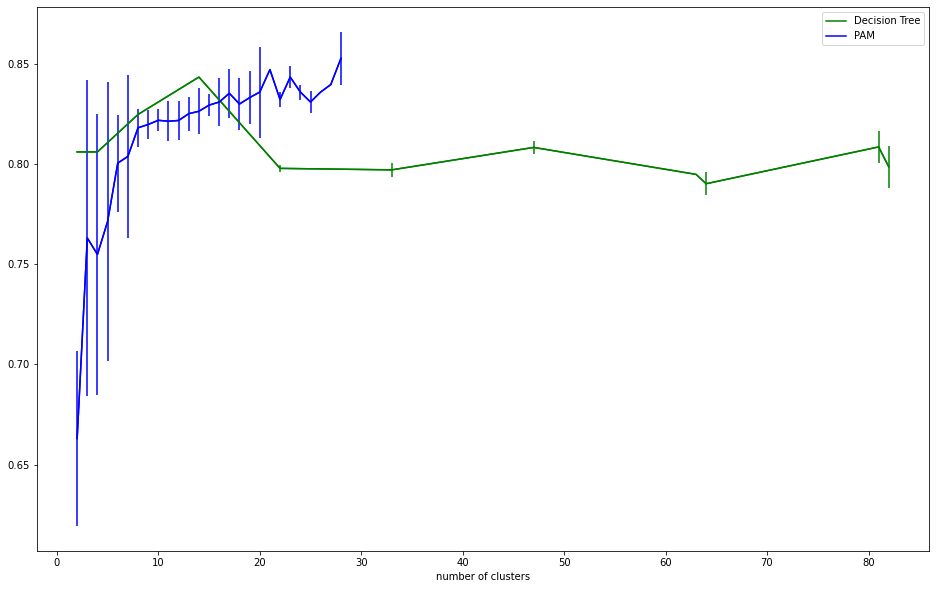

In [414]:
#Plots
plt.figure(figsize = (16,10))
plt.plot(means.index,means['tree_acc'],label = 'Decision Tree',color = 'green')
plt.errorbar(means.index,means['tree_acc'], standards['tree_acc'],color = 'green')

plt.plot(means_clust.index,means_clust['clust_acc'],label = 'PAM',color = 'blue')
plt.errorbar(means_clust.index,means_clust['clust_acc'], standards_clust['clust_acc'],color = 'blue')
plt.legend()
plt.xlabel('number of clusters')